In [19]:
import numpy as np
import matplotlib.pyplot as plt
from modules.utility import generate_player_beliefs, doplots

# Example usage - make the starting probas
import torch
probabilities1 = torch.tensor([1.00-0.01, 0.00+0.01, 0.00+0.01, 0.00+0.01])
probabilities2 = torch.tensor([1.00-0.01, 0.00+0.01, 0.00+0.01, 0.00+0.01])
logits1 = torch.log(probabilities1 / (1 - probabilities1))
logits2 = torch.log(probabilities2 / (1 - probabilities2))
states = ['CC','CB','BC','BB']
P1_beliefs, P2_beliefs = dict(zip(states,logits1)), dict(zip(states,logits2))

# Define the rewards and payoffs
r1, r2 = 3, 3  # Reward for mutual cooperation
t1, t2 = 5, 5  # Temptation payoff
p1, p2 = 0, 0  # Punishment payoff
s1, s2 = 1, 1  # Sucker's payoff
gamma = 0.9    # Discount rate

# Define the rewards matrix
rewards_matrix = np.array([
    [r1, r2],  # Payoffs for when both cooperate
    [p1, t2],  # Payoffs for when one cooperates and the other defects
    [t1, p2],  # Payoffs for when one defects and the other cooperates
    [s1, s2]   # Payoffs for when both defect
])

print("Player 1 Beliefs:", P1_beliefs)
print("Player 2 Beliefs:", P2_beliefs)


Player 1 Beliefs: {'CC': tensor(4.5951), 'CB': tensor(-4.5951), 'BC': tensor(-4.5951), 'BB': tensor(-4.5951)}
Player 2 Beliefs: {'CC': tensor(4.5951), 'CB': tensor(-4.5951), 'BC': tensor(-4.5951), 'BB': tensor(-4.5951)}


[3, 0, 5, 1]
[3 5 0 1]
tensor([0.9900, 0.0100, 0.0100, 0.0100], grad_fn=<SigmoidBackward0>)
tensor([0.9900, 0.0100, 0.0100, 0.0100], grad_fn=<SigmoidBackward0>)
grim trigger - expected cumulative rewards with cooperate,cooperate start
player 1: 27.231714248657227
player 2: 27.231714248657227
grim trigger - expected cumulative rewards with cooperate,betray start
player 1: 9.28255558013916
player 2: 14.282556533813477
grim trigger - expected cumulative rewards with betray,cooperate start
player 1: 14.282556533813477
player 2: 9.282556533813477
grim trigger - expected cumulative rewards with betray,betray start
player 1: 10.282557487487793
player 2: 10.282556533813477
tensor([[27.2317, 27.2317],
        [ 9.2826, 14.2826],
        [14.2826,  9.2826],
        [10.2826, 10.2826]], grad_fn=<MmBackward0>)
done testing
player 1 reward: tensor([[27.2317, 27.2317],
        [ 9.2826, 14.2826],
        [14.2826,  9.2826],
        [10.2826, 10.2826]], grad_fn=<MmBackward0>)
player 1 beliefs: tensor

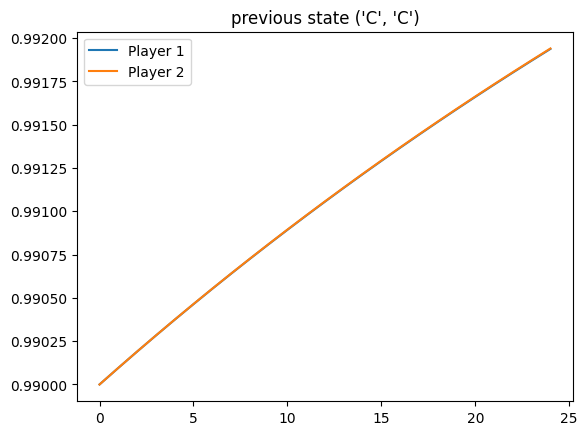

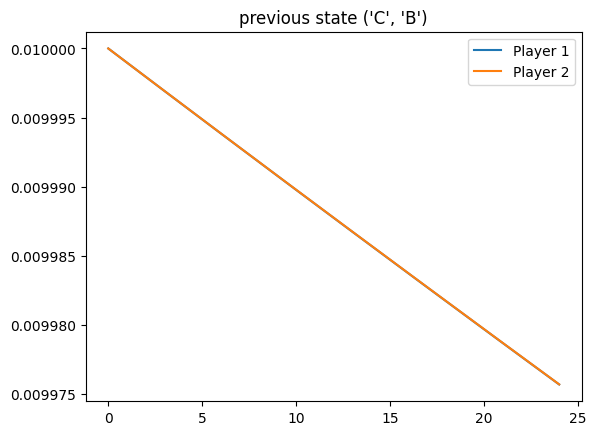

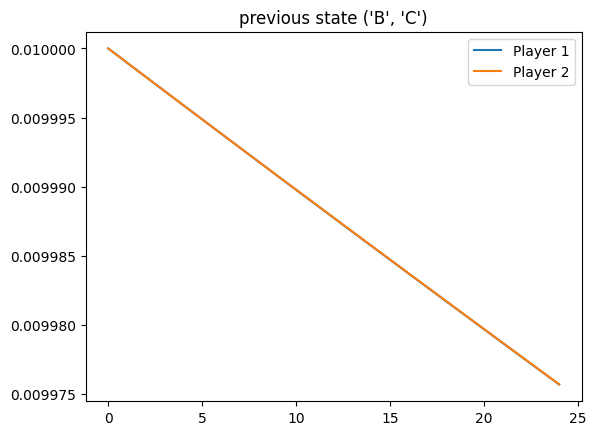

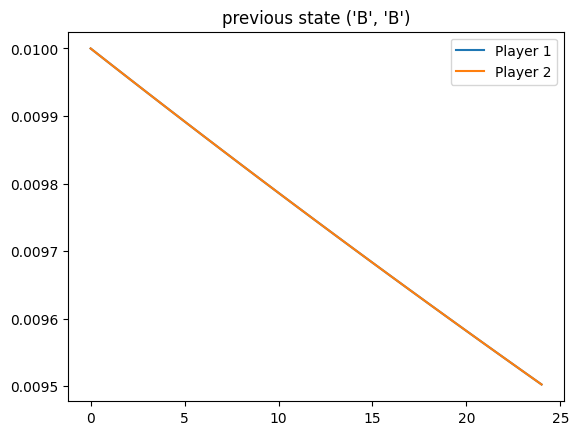

In [20]:
from modules.Player import Player
from modules.PlayerEnv import PlayerEnv
from torch import optim

pl1,pl2=Player(P1_beliefs,list(rewards_matrix[:,0])),Player(P2_beliefs,(rewards_matrix[:,1]))

# Define optimizers for each player
# Assuming that Player class has a method 'parameters()' that returns its parameters
optimizer_p1 = optim.SGD(pl1.parameters(), lr=0.01)
optimizer_p2 = optim.SGD(pl2.parameters(), lr=0.01)

print(pl1.getBeliefs())
print(pl2.getBeliefs())

env=PlayerEnv(pl1,pl2,gamma)

print("grim trigger - expected cumulative rewards with cooperate,cooperate start")
print(f"player 1: {env.play()[0, 0]}")
print(f"player 2: {env.play()[0, 1]}")

print("grim trigger - expected cumulative rewards with cooperate,betray start")
print(f"player 1: {env.play()[1, 0]}")
print(f"player 2: {env.play()[1, 1]}")

print("grim trigger - expected cumulative rewards with betray,cooperate start")
print(f"player 1: {env.play()[2, 0]}")
print(f"player 2: {env.play()[2, 1]}")

print("grim trigger - expected cumulative rewards with betray,betray start")
print(f"player 1: {env.play()[3, 0]}")
print(f"player 2: {env.play()[3, 1]}")

print(env.play())

print("done testing")

# Training loop
num_epochs = 25
plot=[[],[]] #plotting
for epoch in range(num_epochs):

    """
    The first agent adjusts its parameters attempting to maximize the objective
    We fix player 2 while taking the gradient of player 1's reward, with respect to player 1's parameters
    """
    reward = env.play()
    plot[0].append(pl1.getBeliefs()) #plotting
    optimizer_p1.zero_grad()
    loss_p1 = -sum(reward[:, 0]) #start - CC
    loss_p1.backward()
    print(f'player 1 reward: {reward}')
    print(f'player 1 beliefs: {pl1.getBeliefs()}')
    optimizer_p1.step()
    
    """
    The second agent adjusts its parameters attempting to maximize the objective
    We fix player 1 while taking the gradient of player 2's reward, with respect to player 2's parameters
    """
    reward = env.play()
    plot[1].append(pl2.getBeliefs()) #plotting
    optimizer_p2.zero_grad()
    loss_p2 = -sum(reward[:, 1]) #start - CC
    loss_p2.backward()
    print(f'player 2 reward: {reward}')
    print(f'player 2 beliefs: {pl1.getBeliefs()}')
    optimizer_p2.step()

    # Logging
    #if epoch % 10 == 0:
    #    print(f"Epoch {epoch}: pl1 reward = {rp1.sum().item()}, pl2 reward = {rp2.sum().item()}")

doplots(plot)

# Recap:
## Forward Pass:
player beliefs, player beliefs -> transition matrix -> expected cumulative reward, expected cumulative reward
## Problem:
although expected convergence to grim trigger strategy is found for `gamma < .95`, unexpected anomolies appear for higher discount factors, including assymmetric player strategies evolution, and deviation from grim trigger strategy, particularly for the (betray, betray) previous state.

[3, 5, 0, 1]
[3, 0, 5, 1]


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/CGDs/gmres_torch.py:124: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695454711129/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2198.)
  y, _ = torch.triangular_solve(beta[0:j + 1].unsqueeze(-1), H[0:j + 1, 0:j + 1])  # j x j


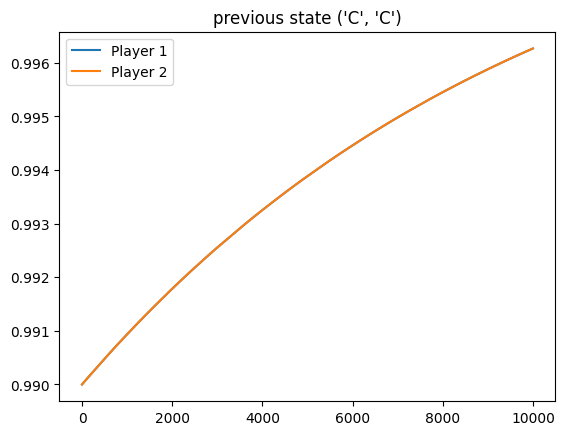

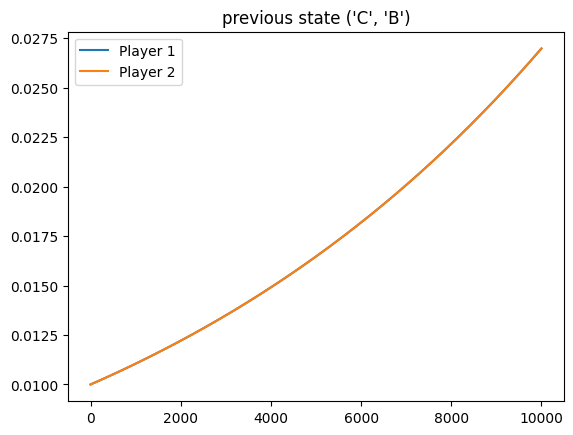

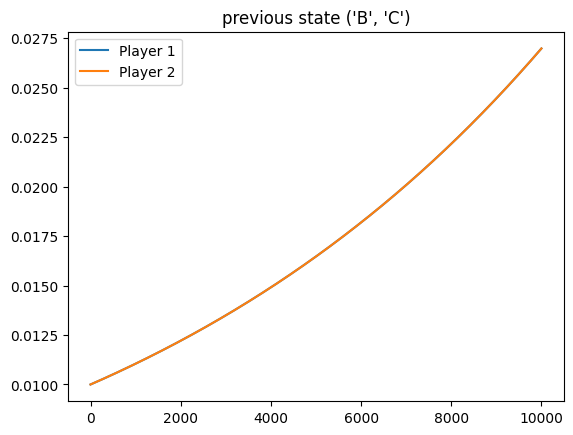

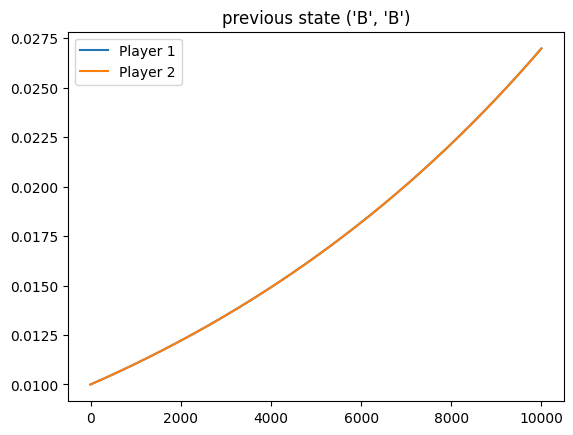

In [3]:
from CGDs import GACGD
from modules.Player import Player
from modules.PlayerEnv import PlayerEnv
lr = 0.0001

pl1=Player(P1_beliefs,[r1,t1,p1,s1])
pl2=Player(P2_beliefs,[r2,p2,t2,s2])
env=PlayerEnv(pl1,pl2,.2)
optimizer = GACGD(x_params=pl1.parameters(), y_params=pl2.parameters(), lr_x=lr, lr_y=lr)

# max_parems is maximizing the objective function while the min_params is trying to minimizing it. 
# BCGD(max_params=G.parameters(), min_params=D.parameters(), lr_max=lr, lr_min=lr, device=device)
# ACGD: Adaptive CGD;
plot=[[],[]] #plotting
for epoch in range(10000):
    """
    An aggregate is taken - the reward of the first player is added, the second player's is subtracted
    First player tries to maximize this
    Second player tries to minimize this
    """
    reward=env.play()
    plot[0].append(pl1.getBeliefs()) #plotting
    plot[1].append(pl2.getBeliefs()) #plotting
    pl1reward = reward[:, 0].sum()
    pl2reward = reward[:, 1].sum()
    optimizer.zero_grad()
    optimizer.step(loss_x=-pl1reward,loss_y=-pl2reward)

doplots(plot)

In [ ]:
print(pl1.ns("B","B"))
print(pl1.ns("B","C"))
print(pl1.ns("C","B"))
print(pl1.ns("C","C"))